In [1]:
"""
Simple setup to compute the normalized flow generative model
"""

import lightning.pytorch as pl
import torch

# import datasrt class
from torch.utils.data import DataLoader


In [2]:

# first we need to generate some simple datasets
def generate_data(nb_cluster_1, nb_cluster_2, nb_samples):
    """
    This function generate 2 dataset :
    - nb_cluster_1 cluster of gaussian
    - nb_cluster_2 cluster of gaussian
    
    Args:
        nb_cluster_1: number of cluster in the first dataset
        nb_cluster_2: number of cluster in the second dataset
        nb_samples: number of samples in the dataset
    
    """
    # set seed
    torch.manual_seed(42)

    # first we generate the random position of the cluster
    cluster_1 = torch.distributions.MultivariateNormal(
        torch.zeros(2), torch.eye(2)
    ).sample((nb_cluster_1,))

    cluster_2 = torch.distributions.MultivariateNormal(
        torch.zeros(2), torch.eye(2)
    ).sample((nb_cluster_2,))

    # then we generate the data
    data_1 = torch.distributions.MultivariateNormal(
        cluster_1, torch.eye(2)/100.
    ).sample((nb_samples,))

    data_2 = torch.distributions.MultivariateNormal(
        cluster_2, torch.eye(2)/100.
    ).sample((nb_samples,))

    return data_1, data_2

data_1, data_2 = generate_data(3, 3, 10000)


    



In [3]:
# now we want to create a simple neural network that represent the probability flow u(t, x)

import torch.nn as nn
import torch.nn.functional as F

class Net(pl.LightningModule):
    def __init__(self):
        super(Net, self).__init__()

        self.sigma = 0.002

        self.fc1 = nn.Linear(3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 2)

        # init weights
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x, t):
        
        x = torch.cat((x, t), 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc5(x)
        return x

    def training_step(self, batch, batch_idx):
        # first we take a look at the batch information
        data_0, data_1 = batch

        batch_size = data_1.size(0)

        # we generate the time between 0 and 1
        t = torch.rand(batch_size, 1)

        mean_sample = t * data_1 + (1 - t) * data_0
        sigma = self.sigma

        # we generate the noise
        noise = torch.randn_like(mean_sample) * sigma + mean_sample

        target = data_1 - data_0

        # then we compute the loss
        loss = F.mse_loss(self(noise, t), target)

        self.log("train_loss", loss)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def generate(self, x_0):
        
        nb_step = 50
        # 50 t value between 0 and 1
        t = torch.linspace(0, 1, nb_step).unsqueeze(0)

        batch = x_0.shape[0]

        t = t.repeat(batch, 1)

        # register the intermediate tensor
        register = []

        for step in range(nb_step):
            t_i = t[:, [step]]
            x_0 = x_0 + self(x_0, t_i) * 1./nb_step
            register.append(x_0.detach().cpu())

        return x_0, register

# create the model
model = Net()

# flatten data_1 and data_2 to be of shape batch_size x 2
data_1 = data_1.view(-1, 2)
data_2 = data_2.view(-1, 2)


# create dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_1, data_2):
        self.data_1 = data_1
        self.data_2 = data_2

    def __len__(self):
        return self.data_1.shape[0]

    def __getitem__(self, idx):
        # we randomly select one element from each dataset
        # data_1 and data_2
        idx_1 = torch.randint(0, self.data_1.shape[0], (1,))[0]

        idx_2 = torch.randint(0, self.data_2.shape[0], (1,))[0]

        return self.data_1[idx_1], self.data_2[idx_2]

dataset = Dataset(data_1, data_2)

# create dataloader
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# wandb logger 
logger = pl.loggers.WandbLogger(project="normalizeflow")

# create trainer
trainer = pl.Trainer(max_epochs=200, logger=logger)
trainer.fit(model, dataloader)


        

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: forbu14. Use `wandb login --relogin` to force relogin



  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 400   
1 | fc2  | Linear | 10.1 K
2 | fc5  | Linear | 202   
--------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [ ]:
data_1.shape

torch.Size([50000, 2])

In [4]:


# sample 100 points for the 30000 points
index_random = torch.randperm(data_1.shape[0])[:100]
data_1_sample = data_1[index_random]
data_2_sample = data_2[index_random]


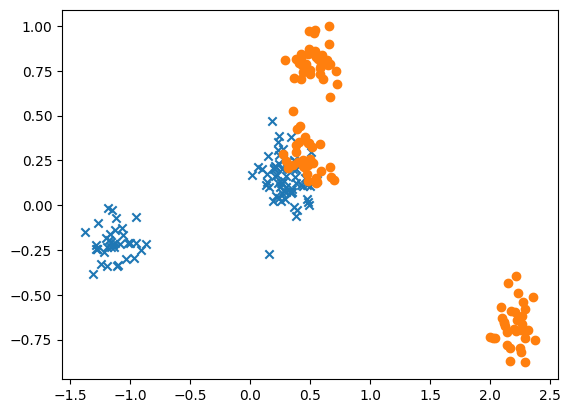

In [5]:
# plot sample
import matplotlib.pyplot as plt

plt.scatter(data_1_sample[:, 0], data_1_sample[:, 1], marker="x")
plt.scatter(data_2_sample[:, 0], data_2_sample[:, 1], marker="o")

In [6]:
final_data, register = model.generate(data_1_sample)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


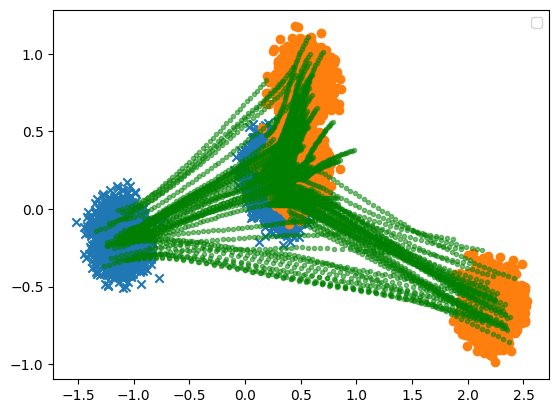

In [7]:
# now we want to plot the data
import matplotlib.pyplot as plt

plt.scatter(data_1[:10000, 0], data_1[:10000, 1], marker="x")
plt.scatter(data_2[:10000, 0], data_2[:10000, 1], marker="o")

# now we want to plot the trajectory
for i in range(len(register)):
    plt.scatter(register[i][:, 0], register[i][:, 1], marker=".",alpha=0.5, color="green")

plt.legend()

plt.show()